# 2m temp MLWP bias over CONUS
## Outline: 
1. imports
2. Model outputs from NOAA
3. Observation data from ERA5
4. Images of output and era5
4. Global
5. CONUS
6. Mediterranean

## Sections 1-3:
This code serves to read in reforecasts NOAA's archive of machine learning weather predicting models and the observations from reanalysis dataset from ECMFW called ERA5. the datasets are accessed entirely from the cloud, meaning you dont have to download anything other than the imports needed to acces the serves.

## Sections 4-6:
Here we take a look at the data from various perspectives: global, CONUS, and Mediterranean. In doing so, we get a more holistic and big picture understanding of what the data looks like at various scales.

The code visualizes the results (as single shots from the forecasts and side by side comparison figures.

## 1. Imports

In [1]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# Direct access
import s3fs # for models
import fsspec # for era5
# also install the package 'gcsfs' for google cloud storage, but importing is not necessary
import pandas as pd
# from io import BytesIO

# datetime
import datetime as dt

# to monitor runtime and help solve errors
from tqdm import tqdm
from func_timeout import func_set_timeout, exceptions

# api to read files
import dask.array as da
import xarray as xr
import h5py

# data process
import numpy as np
import pandas as pd
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, as_completed

# land masking
import cartopy.feature as cfeature
from shapely.geometry import Point, MultiPolygon
from shapely.vectorized import contains

# plot
import matplotlib.pyplot as plt
import matplotlib.animation as anim

import cartopy.crs as ccrs
import cartopy.feature as cfeature

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## 2. Access AWS servers and read forecast data for all three models

In [16]:
# Flag to check if a timeout occurred
flag_timeout = False

# Function to read the file with a timeout
@func_set_timeout(15 * 60)
def readfile(aws_file):
    with xr.open_dataset(aws_file, chunks={'time': 10, 'lat': 50, 'lon': 50}, engine='h5netcdf') as ds:
        t2 = ds.variables['t2'][:]
        lon = ds.variables['longitude'][:]
        lat = ds.variables['latitude'][:]
        time = ds.variables['time'][:]
    return t2, lon, lat, time

# Define model codes and days
model_list = ['GRAP_v100', 'FOUR_v200', 'PANG_v100']
dd_list = ['04', '05']

# Initialize S3 filesystem
s3 = s3fs.S3FileSystem(anon=True)

# Initialize lists to store data
GRAP_t2_list, FOUR_t2_list, PANG_t2_list = [], [], []
GRAP_time_list, FOUR_time_list, PANG_time_list = [], [], []


# Function to process a file
def process_file(model_code, day):
    url_prefix = f's3://noaa-oar-mlwp-data/{model_code}/2023/05{day}/'
    try:
        files = s3.ls(url_prefix)
        if not files:
            print(f"No files found in {url_prefix}")
            return None
        
        aws_file = f's3://{files[0]}'  # Use first file
        print(f"Processing file: {aws_file}")
        f = s3.open(aws_file, 'rb')
        return readfile(f)
    
    except exceptions.FunctionTimedOut:
        print(f"Timeout occurred for {aws_file}")
        return None

# Function to read and process files sequentially
def sequential_process():
    for model in model_list:
        for day in dd_list:
            result = process_file(model, day)
            if result:
                t2, lon, lat, time = result
                if model == 'GRAP_v100':
                    GRAP_t2_list.append(t2)
                    GRAP_time_list.append(time)
                elif model == 'FOUR_v200':
                    FOUR_t2_list.append(t2)
                    FOUR_time_list.append(time)
                elif model == 'PANG_v100':
                    PANG_t2_list.append(t2)
                    PANG_time_list.append(time)

# Process files sequentially
sequential_process()

# Print the number of files processed
total_files_processed = len(GRAP_t2_list) + len(FOUR_t2_list) + len(PANG_t2_list)
print(f"Number of files processed: {total_files_processed}")


Processing file: s3://noaa-oar-mlwp-data/GRAP_v100/2023/0504/GRAP_v100_GFS_2023050400_f000_f240_06.nc
Processing file: s3://noaa-oar-mlwp-data/GRAP_v100/2023/0505/GRAP_v100_GFS_2023050500_f000_f240_06.nc
Processing file: s3://noaa-oar-mlwp-data/FOUR_v200/2023/0504/FOUR_v200_GFS_2023050400_f000_f240_06.nc
Processing file: s3://noaa-oar-mlwp-data/FOUR_v200/2023/0505/FOUR_v200_GFS_2023050500_f000_f240_06.nc
Processing file: s3://noaa-oar-mlwp-data/PANG_v100/2023/0504/PANG_v100_GFS_2023050400_f000_f240_06.nc
Processing file: s3://noaa-oar-mlwp-data/PANG_v100/2023/0505/PANG_v100_GFS_2023050500_f000_f240_06.nc
Number of files processed: 6


In [3]:
dt_list = [pd.to_datetime(forecast) for forecast in GRAP_time_list]

In [14]:
dt_list

[<xarray.IndexVariable 'time' (time: 41)>
 array(['2023-05-05T00:00:00.000000000', '2023-05-05T06:00:00.000000000',
        '2023-05-05T12:00:00.000000000', '2023-05-05T18:00:00.000000000',
        '2023-05-06T00:00:00.000000000', '2023-05-06T06:00:00.000000000',
        '2023-05-06T12:00:00.000000000', '2023-05-06T18:00:00.000000000',
        '2023-05-07T00:00:00.000000000', '2023-05-07T06:00:00.000000000',
        '2023-05-07T12:00:00.000000000', '2023-05-07T18:00:00.000000000',
        '2023-05-08T00:00:00.000000000', '2023-05-08T06:00:00.000000000',
        '2023-05-08T12:00:00.000000000', '2023-05-08T18:00:00.000000000',
        '2023-05-09T00:00:00.000000000', '2023-05-09T06:00:00.000000000',
        '2023-05-09T12:00:00.000000000', '2023-05-09T18:00:00.000000000',
        '2023-05-10T00:00:00.000000000', '2023-05-10T06:00:00.000000000',
        '2023-05-10T12:00:00.000000000', '2023-05-10T18:00:00.000000000',
        '2023-05-11T00:00:00.000000000', '2023-05-11T06:00:00.00000000

In [ ]:
print(f't2_list starts on {dt_list[0][0]} and ends on {dt_list[-1][-1]}')

## 3. Access google cloud storgate and read in ERA5

In [ ]:
# https://storage.googleapis.com/gcp-public-data-arco-era5/raw/date-variable-single_level/2023/07/01/2m_temperature/surface.nc

# gcp-public-data-arco-era5/raw/date-variable-single_level/1940/01/01/2m_temperature

In [ ]:
import fsspec
from pathlib import Path

# Define the parameters
year = '2023'
month = '05'
var = '2m_temperature'
last_day = int(dd_list[-1])  # get the last day of dd_list as an integer
days_list = dd_list + [f'{day:02}' for day in range(last_day + 1, last_day + 11)]

# Initialize filesystem for GCS
fs = fsspec.filesystem('gcs')

# Function to process a single day's data
def process_day(day):
    gcs_path = f'gs://gcp-public-data-arco-era5/raw/date-variable-single_level/{year}/{month}/{day}/{var}/surface.nc'
    
    try:
        with fs.open(gcs_path) as f:
            dataset = xr.open_dataset(f)
            era_dt = dataset.variables['time'][:]
            t2_ERA5 = dataset.variables['t2m'][:]
            # Adjust and return the required data
            adj_era_dt = era_dt[0:-1:6]
            adj_era_t2 = t2_ERA5[0:-1:6]
            return np.array(adj_era_dt), adj_era_t2
    except Exception as e:
        print(f"Error processing {gcs_path}: {e}")
        return None, None

# Initialize lists to store results
era_dt_list, era_t2_list = [], []

# Process all days concurrently
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_day, day): day for day in days_list}
    
    for future in as_completed(futures):
        adj_era_dt, adj_era_t2 = future.result()
        if adj_era_dt is not None:
            era_dt_list.append(adj_era_dt)
            era_t2_list.append(adj_era_t2)

# Concatenate the results into arrays
era_dt_array = np.concatenate(era_dt_list)
era_t2_array = np.concatenate(era_t2_list, axis=0)

In [ ]:
print(f'era_t2_array starts on {era_dt_array[0]} and ends on {era_dt_array[-1]}')

## Visulaizing forecast results

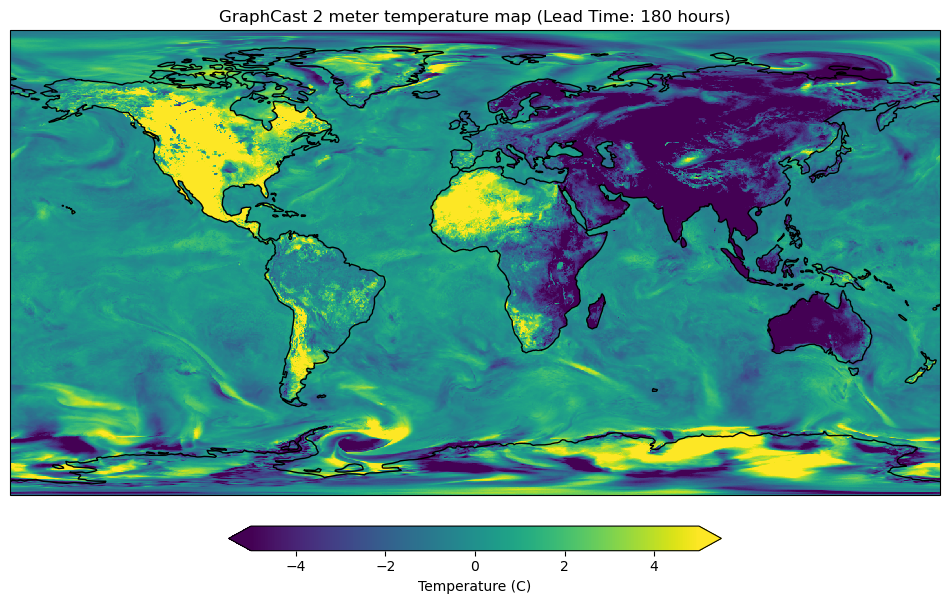

In [9]:
# MAP PARAM
forecast_index = 0    # right now I have the 10 day forecast for may 4th and 5th
frame_index = 30    # a number between 0 and 40

# Plotting the masked data for CONUS
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
# ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.STATES, linestyle=':')

# Add ocean and land for better contrast
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')

# Plot the data
mesh = ax.pcolormesh(lon, lat, GRAP_t2_list[forecast_index][frame_index,:,:]-273.15, 
                     cmap='viridis', vmin=-5, vmax=5, shading='auto', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(mesh, ax=ax, fraction=0.04, orientation='horizontal', pad=0.05, extend='both')
cbar.set_label('Temperature (C)')

# Add titles and labels
plt.title(f'GraphCast 2 meter temperature map (Lead Time: {frame_index*6} hours)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# plt.savefig('GRAP_CONUS_BIAS.png')
# Show the plot
plt.show()

In [ ]:
# subplot params
frame_index = [0,12,28,40] # 00 UTC approx 8pm EST
t2_list = [GRAP_t2_list, FOUR_t2_list, PANG_t2_list]
model_list = ['GraphCast', 'FourCastNet', 'Pangu-Weather']
froecast_index = [range(len(GRAP_t2_list))]

# Figure
fig, ax = plt.subplots(len(frame_index), len(t2_list), figsize=(22, 20), subplot_kw={'projection': ccrs.PlateCarree()})

for i in range(len(frame_index)):
    for j in tqdm(range(len(t2_list))):
        # ax[i, j].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        # ax[i, j].add_feature(cfeature.BORDERS, linestyle=':')
        ax[i, j].add_feature(cfeature.COASTLINE)
        # ax[i, j].add_feature(cfeature.STATES, linestyle=':')
        # ax[i, j].add_feature(cfeature.OCEAN, zorder=0)
        # ax[i, j].add_feature(cfeature.LAND, zorder=0, edgecolor='black')

        # Plotting the data
        mesh = ax[i, j].pcolormesh(
            lon, lat, t2_list[j][forecast_index][frame_index[i]]-273.15, 
            cmap='viridis', shading='auto', 
            transform=ccrs.PlateCarree()
        )
        
        # Set title with model name and datetime
        ax[i, j].set_title(f'{model_list[j]}, Lead Time: {frame_index[i]*6} hours, Datetime: (HERE)')

        # Remove ticks for cleaner appearance
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
# Adjust layout to minimize empty space
plt.subplots_adjust(wspace=0.2, hspace=0.2, top=0.92, bottom=0.08, left=0.05, right=0.98)

# Set color bar and label
cbar = fig.colorbar(mesh, ax=ax, orientation='horizontal', fraction=0.05, pad=0.04, extend='both')
cbar.set_label('Temperature Bias (K)')

plt.suptitle('Global 2m Temperature Forecast (00 UTC / 20 EST)', fontsize=20)
# plt.savefig('TEST.png')
plt.show()


## 4. GLOBAL

### 4.1 Global land mask vs ocean mask bias

first taking the bias, then masking the data

In [ ]:
# Initialize lists to store biases
GRAP_bias_list, FOUR_bias_list, PANG_bias_list = [], [], []

# Precompute reshaping of ERA5 data and calculate biases
for i in range(len(GRAP_t2_list)):
    era_reshaped = era_t2_array[i*4:(i*4)+41, :, :]  # Extract and reshape in one step
    GRAP_bias_list.append(GRAP_t2_list[i] - era_reshaped)
    FOUR_bias_list.append(FOUR_t2_list[i] - era_reshaped)
    PANG_bias_list.append(PANG_t2_list[i] - era_reshaped)

In [ ]:
# Generate longitude grid and adjust lon values
lon_adj = np.where(lon < 180, lon, lon - 360)
lon_grid, lat_grid = np.meshgrid(lon_adj, lat)

# Land mask creation using Cartopy and GSHHS
land_feature = cfeature.GSHHSFeature(scale='high')
land_geometries = list(land_feature.geometries())
land_multipolygon = MultiPolygon(land_geometries)
land_mask = contains(land_multipolygon, lon_grid, lat_grid)

In [ ]:
# Applying land mask to biases
def apply_land_mask(bias_list):
    masked_bias_list = []
    for forecast in bias_list:
        masked_forecast = []
        for time_step in range(forecast.shape[0]):  # Loop through each time step
            masked_time_step = np.ma.masked_where(~land_mask, forecast[time_step])
            masked_forecast.append(masked_time_step)
        masked_forecast = np.ma.stack(masked_forecast)  # Stack the time steps back into a single array
        masked_bias_list.append(masked_forecast)
    return masked_bias_list

GRAP_land_bias_list = apply_land_mask(GRAP_bias_list)
FOUR_land_bias_list = apply_land_mask(FOUR_bias_list)
PANG_land_bias_list = apply_land_mask(PANG_bias_list)

### 4.2 Visualize

In [ ]:
# Plotting parameters
forecast_index = 0  # Use first forecast
frame_index = 40     # Use the second frame

# Plotting
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')

mesh = ax.pcolormesh(lon_grid, lat_grid, GRAP_land_bias_list[forecast_index][frame_index], 
                     cmap='coolwarm', shading='auto', transform=ccrs.PlateCarree())

cbar = plt.colorbar(mesh, ax=ax, fraction=0.04, orientation='horizontal', pad=0.05, extend='both')
cbar.set_label('Temperature (C)')
plt.title(f'GraphCast 2 meter temperature Bias (Lead Time: {frame_index * 6} hours)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### 4.3 RMSE

In [ ]:
# Calculate RMSE for each frame in the land masked bias list
def calculate_rmse(bias_list):
    return [[np.sqrt(np.mean(frame**2)) for frame in forecast] for forecast in bias_list]

grap_land_rmse_list = calculate_rmse(GRAP_land_bias_list)
four_land_rmse_list = calculate_rmse(FOUR_land_bias_list)
pang_land_rmse_list = calculate_rmse(PANG_land_bias_list)

In [ ]:
# creating the lead time array to match the bias list's order (from 240 hrs to the 0th hour)
x_array = np.arange(0,6*len(grap_land_rmse_list[0]),6)
x_array

In [ ]:
land_rmse_list = [grap_land_rmse_list, four_land_rmse_list, pang_land_rmse_list]
start_date_index = 1
# equation_text = r'$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}  %.2f$' 
# plt.text(160, 1.5, equation_text, fontsize=10, 
#          # color='red'
#         )

plt.plot(x_array, land_rmse_list[0][start_date_index], marker='o', label='GrapCast')
plt.plot(x_array, land_rmse_list[1][start_date_index], marker='o', label='FourCast')
plt.plot(x_array, land_rmse_list[2][start_date_index], marker='o', label='Pangu')
plt.xlabel('Lead Time (hours)')
plt.ylabel('RMSE (Celcius)')
plt.title('Global land RMSE vs Lead Time DATETIME')
plt.legend()
plt.grid(True)
# plt.savefig('GRAP_RMSE.png')
plt.show()


## 5. CONUS

### 5.1 Mask

In [ ]:
# Adjust longitude from 0-360 to -180-180
lon_adj = np.where(lon < 180, lon, lon - 360)

# Generate a grid that matches your dataset
lon_grid, lat_grid = np.meshgrid(lon_adj, lat)

# Define the bounding box for the CONUS
lon_min, lon_max = -125, -66
lat_min, lat_max = 25, 50

# Create a mask for the CONUS bounding box
bbox_mask = (lon_grid >= lon_min) & (lon_grid <= lon_max) & (lat_grid >= lat_min) & (lat_grid <= lat_max)

# Use GSHHS dataset for land features and create a land mask
land_feature = cfeature.GSHHSFeature(scale='high')
land_geometries = list(land_feature.geometries())
land_multipolygon = MultiPolygon(land_geometries)
land_mask = contains(land_multipolygon, lon_grid, lat_grid)

# Combine the bounding box mask with the land mask
CONUS_mask = bbox_mask & land_mask

In [ ]:
# Initialize lists to store the masked bias data for each model
GRAP_CONUS_bias_list, FOUR_CONUS_bias_list, PANG_CONUS_bias_list = [], [], []

# Loop through each forecast
for start_date_index in range(len(GRAP_bias_list)):
    # Initialize sublists for each forecast
    GRAP_sublist, FOUR_sublist, PANG_sublist = [], [], []

    # Loop through each frame within the forecast
    for lead_time_index in tqdm(range(len(GRAP_bias_list[start_date_index]))):
        # Apply the CONUS mask and append the masked bias data to the corresponding sublists
        GRAP_sublist.append(np.ma.masked_where(~CONUS_mask, GRAP_bias_list[start_date_index][lead_time_index]))
        FOUR_sublist.append(np.ma.masked_where(~CONUS_mask, FOUR_bias_list[start_date_index][lead_time_index]))
        PANG_sublist.append(np.ma.masked_where(~CONUS_mask, PANG_bias_list[start_date_index][lead_time_index]))

    # Append the sublists to the main lists
    GRAP_CONUS_bias_list.append(GRAP_sublist)
    FOUR_CONUS_bias_list.append(FOUR_sublist)
    PANG_CONUS_bias_list.append(PANG_sublist)


In [ ]:
# Function to apply the CONUS mask to bias data
def apply_conus_mask(bias_list, conus_mask):
    masked_bias_list = []
    for forecast in bias_list:
        masked_forecast = []
        for time_step in range(forecast.shape[0]):  # Loop through each time step
            masked_time_step = np.ma.masked_where(~conus_mask, forecast[time_step])
            masked_forecast.append(masked_time_step)
        masked_forecast = np.ma.stack(masked_forecast)  # Stack the time steps back into a single array
        masked_bias_list.append(masked_forecast)
    return masked_bias_list

# Apply the CONUS mask to each model's bias list
GRAP_CONUS_bias_list = apply_conus_mask(GRAP_bias_list, CONUS_mask)
FOUR_CONUS_bias_list = apply_conus_mask(FOUR_bias_list, CONUS_mask)
PANG_CONUS_bias_list = apply_conus_mask(PANG_bias_list, CONUS_mask)


#### MULTIPROCESSING (couldnt get it to work)

In [ ]:
def process_frame(args):
    combined_mask, GRAP_frame, FOUR_frame, PANG_frame = args

    GRAP_masked_bias_data = np.ma.masked_where(~combined_mask, GRAP_frame)
    FOUR_masked_bias_data = np.ma.masked_where(~combined_mask, FOUR_frame)
    PANG_masked_bias_data = np.ma.masked_where(~combined_mask, PANG_frame)
    
    return GRAP_masked_bias_data, FOUR_masked_bias_data, PANG_masked_bias_data

In [ ]:
# Create lists to hold the final results
GRAP_masked_bias_list = []
FOUR_masked_bias_list = []
PANG_masked_bias_list = []

# Define the number of processes to use
num_processes = mp.cpu_count()  # Use all available CPUs

# Initialize a pool of processes
with mp.Pool(processes=num_processes) as pool:
    # Loop through each forecast
    for start_date_index in range(len(GRAP_bias_list)):
        # Prepare the input for multiprocessing
        input_data = [(combined_mask, 
                       GRAP_bias_list[start_date_index][lead_time_index], 
                       # FOUR_bias_list[start_date_index][lead_time_index], 
                       # PANG_bias_list[start_date_index][lead_time_index]
                      ) 
                      for lead_time_index in range(len(GRAP_bias_list[start_date_index]))]

        # Use pool.imap to process all frames in parallel and wrap it with tqdm
        results = list(tqdm(pool.imap(process_frame, input_data), total=len(input_data), desc=f'Forecast {start_date_index + 1}/{len(GRAP_bias_list)}'))

        # Unzip the results and append them to the respective lists
        GRAP_forecast_bias, FOUR_forecast_bias, PANG_forecast_bias = zip(*results)

        GRAP_masked_bias_list.append(GRAP_forecast_bias)
        FOUR_masked_bias_list.append(FOUR_forecast_bias)
        PANG_masked_bias_list.append(PANG_forecast_bias)


In [ ]:
np.shape(GRAP_masked_bias_list)

### 5.2 Visualize

In [ ]:
# Plotting parameters
CONUS_bias_list = [GRAP_CONUS_bias_list, FOUR_CONUS_bias_list, PANG_CONUS_bias_list]
forecast_index = 1    # right now I have the 10 day forecast for may 4th and 5th
frame_index = 4    # a number between 0 and 40

# Plotting the masked data for CONUS
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')

mesh = ax.pcolormesh(lon_grid, lat_grid, CONUS_bias_list[0][forecast_index][frame_index], cmap='coolwarm',vmin=-10, vmax=10, shading='auto', transform=ccrs.PlateCarree())

cbar = plt.colorbar(mesh, ax=ax, fraction=0.04, orientation='horizontal', pad=0.05, extend='both')
cbar.set_label('Bias (K)')

plt.title(f'GraphCast 2 meter temperature Bias (Lead Time: {frame_index*6} hours)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# plt.savefig('GRAP_CONUS_BIAS.png')
plt.show()

In [ ]:
# Plotting parameters
frame_index = [0, 12, 28, 40]  # 00 UTC approx 8pm EST
masked_bias_list = [GRAP_CONUS_bias_list, FOUR_CONUS_bias_list, PANG_CONUS_bias_list]
model_list = ['GraphCast', 'FourCastNet', 'Pangu-Weather']

# Figure settings
fig, ax = plt.subplots(len(frame_index), len(model_list), figsize=(30, 23), subplot_kw={'projection': ccrs.PlateCarree()})

# Loop through each frame and model
for i, frame in enumerate(frame_index):
    for j, model in enumerate(masked_bias_list):
        # Set map extent and add features
        ax[i, j].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax[i, j].add_feature(cfeature.BORDERS, linestyle=':')
        ax[i, j].add_feature(cfeature.COASTLINE)
        ax[i, j].add_feature(cfeature.STATES, linestyle=':')
        ax[i, j].add_feature(cfeature.OCEAN, zorder=0)
        ax[i, j].add_feature(cfeature.LAND, zorder=0, edgecolor='black')

        # Plot the data
        mesh = ax[i, j].pcolormesh(
            lon_grid, lat_grid, model[0][frame],  # Using the first forecast set for simplicity
            cmap='coolwarm', vmin=-10, vmax=10, shading='auto', transform=ccrs.PlateCarree()
        )
        
        # Set title with model name and lead time
        lead_time_hours = frame * 6
        ax[i, j].set_title(f'{model_list[j]} Model\nLead Time: {lead_time_hours} hrs', fontsize=14)

        # Remove ticks for cleaner appearance
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

# Adjust layout to minimize empty space
plt.subplots_adjust(wspace=0.1, hspace=0.2, top=0.92, bottom=0.08, left=0.05, right=0.98)

# Set color bar and label
cbar = fig.colorbar(mesh, ax=ax, orientation='horizontal', fraction=0.03, pad=0.04, extend='both')
cbar.set_label('Temperature Bias (K)', fontsize=16)

# Add a super title
plt.suptitle('CONUS 2m Temperature Forecast (00 UTC / 20 EST)', fontsize=24)

# Display the plot
plt.show()


### 5.3 RMSE

In [ ]:
# Calculate RMSE for each frame in the land masked bias list
def calculate_rmse(bias_list):
    return [[np.sqrt(np.mean(frame**2)) for frame in forecast] for forecast in bias_list]

grap_CONUS_rmse_list = calculate_rmse(GRAP_CONUS_bias_list)
four_CONUS_rmse_list = calculate_rmse(FOUR_CONUS_bias_list)
pang_CONUS_rmse_list = calculate_rmse(PANG_CONUS_bias_list)

In [ ]:
# creating the lead time array to match the bias list's order (from 240 hrs to the 0th hour)
x_array = np.arange(0,6*len(rmse_list[0]),6)
x_array

In [ ]:
CONUS_rmse_list = [grap_CONUS_rmse_list, four_land_rmse_list, pang_land_rmse_list]
start_date_index = 1
# equation_text = r'$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}  %.2f$' 
# plt.text(160, 1.5, equation_text, fontsize=10, 
#          # color='red'
#         )

plt.plot(x_array, land_rmse_list[0][start_date_index], marker='o', label='GrapCast')
plt.plot(x_array, land_rmse_list[1][start_date_index], marker='o', label='FourCast')
plt.plot(x_array, land_rmse_list[2][start_date_index], marker='o', label='Pangu')
plt.xlabel('Lead Time (hours)')
plt.ylabel('RMSE (Celcius)')
plt.title('Global land RMSE vs Lead Time')
plt.legend()
plt.grid(True)
# plt.savefig('GRAP_RMSE.png')
plt.show()


In [ ]:
plt.figure()
plt.plot(x_array, rmse_list[1], marker='o')
plt.xlabel('Lead Time (hours)')
plt.ylabel('RMSE ()')
plt.title('GraphCast RMSE vs Lead Time')
plt.grid(True)
# plt.savefig('GRAP_RMSE.png')
plt.show()

In [ ]:
CONUS_rmse_list = [grap_rmse_list, four_rmse_list, pang_rmse_list]

equation_text = r'$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}  %.2f$' 
plt.text(160, 1.5, equation_text, fontsize=10, 
         # color='red'
        )

plt.plot(x_array, CONUS_rmse_list[0][1], marker='o', label='GrapCast')
plt.plot(x_array, CONUS_rmse_list[1][1], marker='o', label='FourCast')
plt.plot(x_array, CONUS_rmse_list[2][1], marker='o', label='Pangu')
plt.xlabel('Lead Time (hours)')
plt.ylabel('RMSE (Celcius)')
plt.title('CONUS RMSE vs Lead Time')
plt.legend()
plt.grid(True)
# plt.savefig('GRAP_RMSE.png')
plt.show()


## 6. Mediterranean

### 6.1 Mask

### 6.2 Visualize

### 6.3 RMSE